In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit
import seaborn as sns
import torch

import warnings
sns.set_style("ticks")
#warnings.filterwarnings('ignore')
#warnings.simplefilter('ignore')

## Generate Data

In [2]:
dims = [100]

In [3]:
from sklearn.datasets import make_classification, make_blobs
# Cluster of points normally distributed (std=1) about vertices
# of an n_informative-dim hypercube with sides of length 2*class_sep

# Features are ordered: n_informative, n_redundant, n_repeated, 
# then random noise
def generate_samples(n_features, n_informative, n_samples=100):
    """
    return make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=2,
        random_state=42
        
    )
    """
    return make_classification(
        n_samples=n_samples, 
        n_features=n_features, 
        n_informative=n_informative,
        n_redundant=0, 
        n_repeated=0, 
        n_classes=2, 
        n_clusters_per_class=1, 
        flip_y=0.01, 
        class_sep=2, 
        random_state=42,
        shuffle=False
    )

X = dict()
y = dict()
for i in dims:
    X[i], y[i] = generate_samples(i, i)

### Projection onto 2 Dimensions

In [4]:
from sklearn.decomposition import PCA

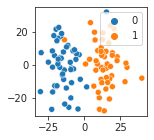

In [5]:
pca = dict()
X_reduced = dict()

for i in dims:
    pca[i] = PCA(n_components=2)
    X_reduced[i] = pca[i].fit_transform(X[i])
    plt.figure(figsize=(2,2))
    sns.scatterplot(x=X_reduced[i][:,0], y=X_reduced[i][:,1], hue=y[i])

## Linear Separator

In [6]:
from sklearn.svm import LinearSVC

clf = dict()
for i in dims:
    clf[i] = LinearSVC(random_state=42, max_iter=1000)
    clf[i].fit(X[i], y[i])

In [7]:
for i in dims:
    y[i][y[i] == 0] = -1
    y[i]

In [8]:
w_norm = dict()
for i in dims:
    w_norm[i] = np.linalg.norm(clf[i].coef_)

### Reload Training Data

In [9]:
X_sel = dict()
y_sel = dict()
for i in dims:
    rs = ShuffleSplit(n_splits=1, train_size=16, random_state=42)
    # Recover the exact indices used for training (kind of hacky)
    for train_index, test_index in rs.split(X[i]):
        X_sel[i], y_sel[i] = X[i][train_index], y[i][train_index]

### Reload Best Attacker Data and Plot Graphs

In [44]:
def get_raw_report(ada, lamb, dim):
    if ada:
        report = torch.load(f"gaussian_adazoro_lambda{lamb}_d{dim}_20220616_report.pt")
    else:
        report = torch.load(f"gaussian_zoro_lambda{lamb}_d{dim}_20220616_report.pt")

    return report

def compile_report(ada, lamb, dim):
    report = get_raw_report(ada, lamb, dim)
    
    data_point = []

    iteration = []
    number_evals = []
    perturbation_norms = []
    predictions = []
    labels = []

    for i in range(len(report)):
        data_point.extend([i] * len(report[i]))
        original = report[i][0]["x"]
        labels.extend([report[i][0]["y"]] * len(report[i]))

        iteration.extend(range(len(report[i])))
        number_evals.extend(report[i][j]["evals"] for j in range(len(report[i])))
        perturbation_norms.extend([np.linalg.norm(original - report[i][j]["x"], 2) for j in range(len(report[i]))])
        predictions.extend(clf[dim].decision_function(np.stack([report[i][j]["x"] for j in range(len(report[i]))]))/w_norm[dim].tolist())

    results_df = pd.DataFrame(
        {"data_point" : data_point,
         "iteration" : iteration,
         "num_evals": number_evals,
         "perturbation": perturbation_norms,
         "distance": predictions,
         "label" : labels,
         "optimizer": len(labels) * ["AdaZORO" if ada else "ZORO"],
         "lambda" : len(labels) * [lamb],
         "dimensionality" : len(labels) * [dim]
        }
    )
    
    return results_df

In [45]:
report_ada_d100_lamb_01 = compile_report(True, 0.01, 100)
report_ada_d100_lamb_05 = compile_report(True, 0.05, 100)
report_ada_d100_lamb_10 = compile_report(True, 0.10, 100)

#report_ada_d10_lamb_01 = compile_report(True, 0.01, 10)
#report_ada_d10_lamb_05 = compile_report(True, 0.05, 10)
#report_ada_d10_lamb_10 = compile_report(True, 0.10, 10)

report_zoro_d100_lamb_01 = compile_report(False, 0.01, 100)
report_zoro_d100_lamb_05 = compile_report(False, 0.05, 100)
report_zoro_d100_lamb_10 = compile_report(False, 0.10, 100)

#report_zoro_d10_lamb_01 = compile_report(False, 0.01, 10)
#report_zoro_d10_lamb_05 = compile_report(False, 0.05, 10)
#report_zoro_d10_lamb_10 = compile_report(False, 0.10, 10)

In [46]:
report_all = pd.concat([report_ada_d100_lamb_01,
                            report_ada_d100_lamb_05,
                            report_ada_d100_lamb_10,
                            report_zoro_d100_lamb_01,
                            report_zoro_d100_lamb_05,
                            report_zoro_d100_lamb_10]).reset_index()

#### Fig 1

PCA of Example Point:
1. Original Cluster 1
2. Original Cluster 2
3. Trace of Attack over Iterations

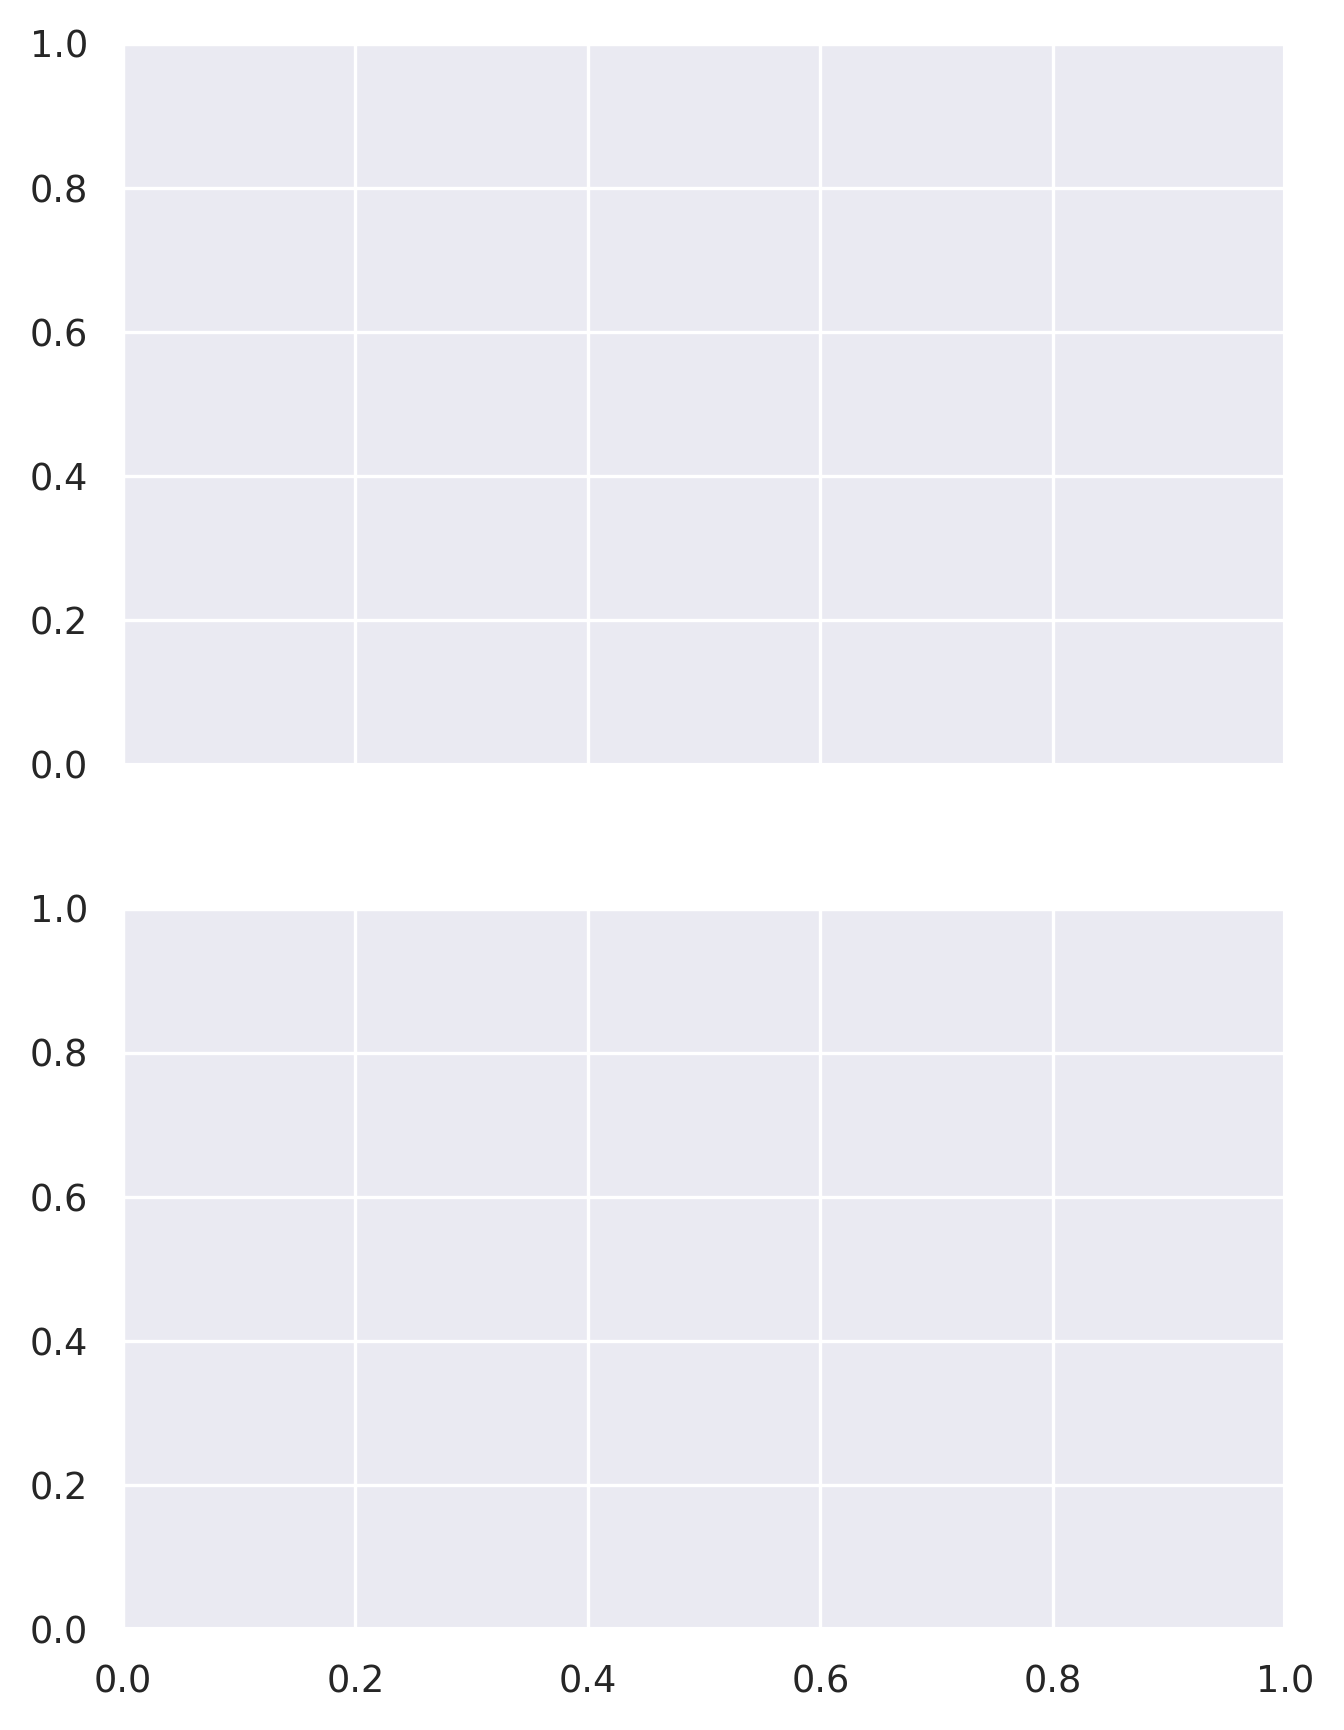

In [163]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 7), dpi=300, sharex=True, sharey=True)

In [164]:
j = 9
#selected = results_df[(results_df["data_point"] == j) & (results_df["iteration"] % 50 == 0)]
ada = False
l = 0.01
d = 100
selected_report = get_raw_report(ada, l, d)

selected_X = np.stack([selected_report[j][i]["x"] for i in range(len(selected_report[j]))])[::10]
reduced_X = pca[100].transform(selected_X)

axs[0].set_title(f"ZORO", size=12, loc="left")
axs[0].set_ylabel("Dimension 2", size=12)
sns.scatterplot(ax=axs[0], x=X_reduced[100][:,0], y=X_reduced[100][:,1], style=y[100], label="Labels")
sns.scatterplot(ax=axs[0], x=reduced_X[:, 0], y=reduced_X[:, 1], hue=range(len(reduced_X)), marker="D", palette="flare", label="Attack Iter.")
#plt.tight_layout()
#plt.savefig("gaussian_dim100_path.pdf")

<AxesSubplot:title={'left':'ZORO'}, ylabel='Dimension 2'>

In [165]:
j = 9
#selected = results_df[(results_df["data_point"] == j) & (results_df["iteration"] % 50 == 0)]
ada = True
l = 0.05
d = 100
selected_report = get_raw_report(ada, l, d)

selected_X = np.stack([selected_report[j][i]["x"] for i in range(len(selected_report[j]))])[::10]
reduced_X = pca[100].transform(selected_X)

#plt.figure(figsize=(8,5), dpi=300)
axs[1].set_title(f"AdaZORO", size=12, loc="left")
axs[1].set_xlabel("Dimension 1", size=12)
axs[1].set_ylabel("Dimension 2", size=12)
#plt.title(f"{'AdaZORO' if ada else 'ZORO'} with lamba={l} and dimension={d}", size=16)
sns.scatterplot(ax=axs[1], x=X_reduced[100][:,0], y=X_reduced[100][:,1], style=y[100], label="Label")
sns.scatterplot(ax=axs[1], x=reduced_X[:, 0], y=reduced_X[:, 1], hue=range(len(reduced_X)), marker="D", palette="flare", label="Attack Iter.")

<AxesSubplot:title={'left':'AdaZORO'}, xlabel='Dimension 1', ylabel='Dimension 2'>

In [166]:
fig.savefig("gaussian_dim100_path.pdf")

#### Fig 2

Distance from Hyperplane (Vector Norm)

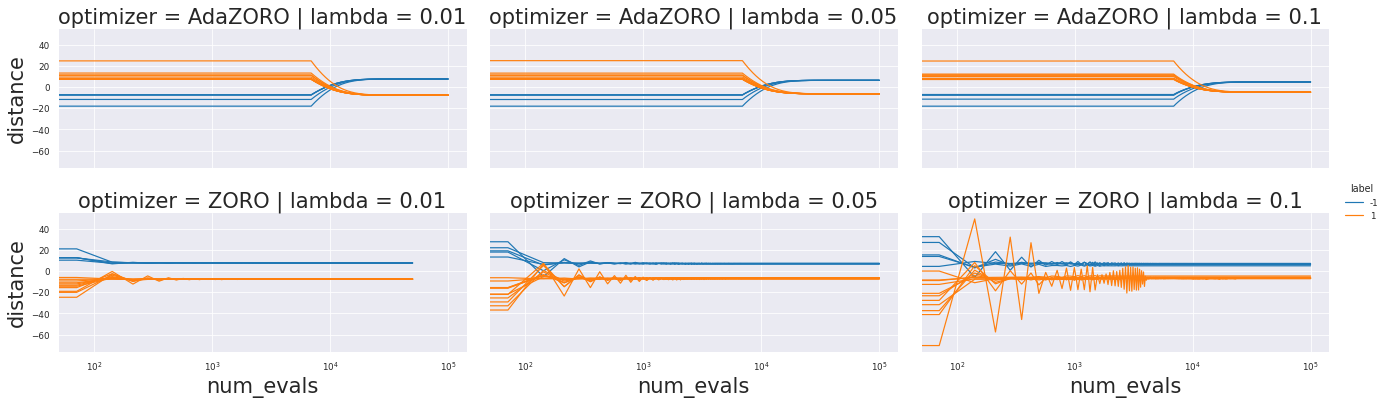

In [50]:
sns.set_context("paper", rc={"font.size":21,"axes.titlesize":21,"axes.labelsize":21})   

g = sns.relplot(
    data=report_all, x="num_evals", y="distance",
    row="optimizer", col="lambda", hue="label", units="data_point",
    kind="line", palette="tab10", estimator=None, height=3, 
    aspect=2.1
)
plt.xscale("log")

plt.savefig("gaussian_dim100_distance_norm.pdf")

#### Fig 3

Distance from Input to Attack Vector (Vector Norm)

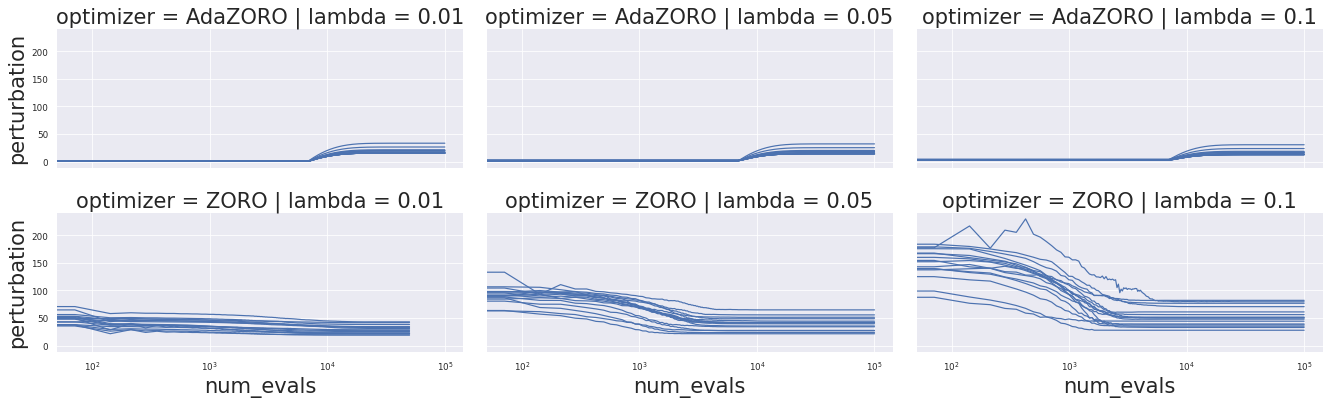

In [52]:
sns.relplot(
    data=report_all, x="num_evals", y="perturbation",
    row="optimizer", col="lambda", units="data_point", estimator=None,
    kind="line", palette="tab10", height=3, aspect=2.1
)
plt.xscale("log")
plt.savefig("gaussian_dim100_perturb_norm.pdf")